In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd 
import seaborn as sns
import plotly.express as px 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/udemy-courses/udemy_courses.csv


In [2]:
df = pd.read_csv('../input/udemy-courses/udemy_courses.csv')

In [3]:
df.drop(['course_id', 'url'],axis = 1, inplace = True)
df.head().transpose()

,0,1,2,3,4
course_title,Ultimate Investment Banking Course,Complete GST Course & Certification - Grow You...,Financial Modeling for Business Analysts and C...,Beginner to Pro - Financial Analysis in Excel ...,How To Maximize Your Profits Trading Options
is_paid,True,True,True,True,True
price,200,75,45,95,200
num_subscribers,2147,2792,2174,2451,1276
num_reviews,23,923,74,11,45
num_lectures,51,274,51,36,26
level,All Levels,All Levels,Intermediate Level,All Levels,Intermediate Level
content_duration,1.5,39.0,2.5,3.0,2.0
published_timestamp,2017-01-18T20:58:58Z,2017-03-09T16:34:20Z,2016-12-19T19:26:30Z,2017-05-30T20:07:24Z,2016-12-13T14:57:18Z
subject,Business Finance,Business Finance,Business Finance,Business Finance,Business Finance


In [4]:
new_df = df['published_timestamp'].str.split('-',expand=True).loc[:,[0,1]].astype('int')
new_df.columns=['year', 'month']
data = pd.concat([df,new_df],axis=1)
data.drop(['published_timestamp'], axis = 1, inplace = True)
data.head()

,course_title,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject,year,month
0,Ultimate Investment Banking Course,True,200,2147,23,51,All Levels,1.5,Business Finance,2017,1
1,Complete GST Course & Certification - Grow You...,True,75,2792,923,274,All Levels,39.0,Business Finance,2017,3
2,Financial Modeling for Business Analysts and C...,True,45,2174,74,51,Intermediate Level,2.5,Business Finance,2016,12
3,Beginner to Pro - Financial Analysis in Excel ...,True,95,2451,11,36,All Levels,3.0,Business Finance,2017,5
4,How To Maximize Your Profits Trading Options,True,200,1276,45,26,Intermediate Level,2.0,Business Finance,2016,12


As it can be seen, there are no null values in the data:

In [5]:
data.describe()

,price,num_subscribers,num_reviews,num_lectures,content_duration,year,month
count,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000
mean,66.049483,3197.150625,156.259108,40.108755,4.094517,2015.431213,6.164220
std,61.005755,9504.117010,935.452044,50.383346,6.053840,1.185317,3.380535
min,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000,1.000000
25%,20.000000,111.000000,4.000000,15.000000,1.000000,2015.000000,3.000000
50%,45.000000,911.500000,18.000000,25.000000,2.000000,2016.000000,6.000000
75%,95.000000,2546.000000,67.000000,45.750000,4.500000,2016.000000,9.000000
max,200.000000,268923.000000,27445.000000,779.000000,78.500000,2017.000000,12.000000


# Categorical data exploration

In [6]:
temp_df = pd.DataFrame(data['subject'].value_counts()).reset_index()
fig = px.pie(temp_df, values='subject', names= 'index', \
             title='Subject category distribution',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [7]:
temp_df = pd.DataFrame(data['level'].value_counts()).reset_index()
fig = px.pie(temp_df, values='level', names= 'index', \
             title='Level category distribution',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

As it can be seen, courses of categories 'Web Development' and 'Business Finance' prevail.
With respect to 'level' category - 'all levels' courses are more than of half of the dataset.

# Number of courses throughout the years

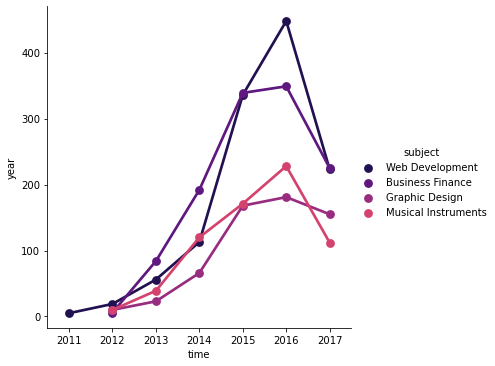

In [8]:
plot_data = data.groupby(['year', 'subject'])['year'].count().to_frame()
plot_data['subject'] = [ x[1] for x in plot_data.index.tolist()]
plot_data.index = [x[0] for x in plot_data.index.tolist()]
plot_data['time'] = plot_data.index
plot_data = plot_data.reset_index(drop=True)
sns.catplot(x = 'time', y="year", hue="subject",palette = sns.color_palette("magma"), kind="point",data=plot_data)
plt.show()

Peak of quantity of 'Web development' courses is higher than 400, which is an absolute record of the observed pattern throughout all years!

All in all, in 2016 the quantity of each type courses achived a peak, but the 'Web development' and 'Business Finance' categories clearly prevail in that period by a wide margin.

# Clustering

The common pattern and structure of the data can be observed through clutering and analysis of the clusters gained, three features for more convenient visualization were chosen, which are: number of lectures, subscribers and reviews.

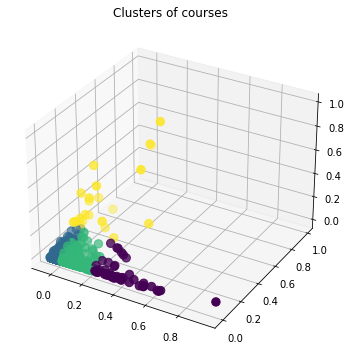

In [9]:
chosen_features = ['num_lectures', 'num_subscribers', 'num_reviews']
x = data.loc[:, chosen_features].values
x_ave = np.mean(x, axis=0)
x_rng = np.ptp(x, axis=0)
x_rng_std = np.divide(np.subtract(x, x_ave), x_rng)
kmeans = KMeans(n_clusters=4, init = 'random', algorithm = 'elkan').fit(x_rng_std)
x = x_rng_std[:, [0]].reshape(-1,)
y = x_rng_std[:, [1]].reshape(-1,)
z = x_rng_std[:, [2]].reshape(-1,)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
data['labels'] = kmeans.labels_
ax.scatter(x, y, z, c = kmeans.labels_, s = 70)
plt.title('Clusters of courses')
plt.show()

Clusters coloring w.r.t. subject

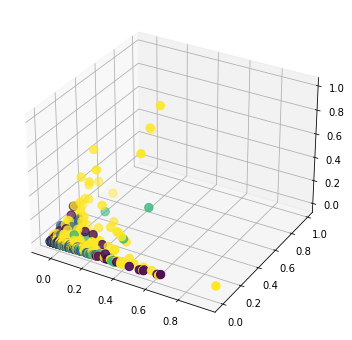

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = data['subject'].map({k:i for i,k in enumerate(data['subject'].unique().tolist())}), s = 70)
plt.show()

Well, obviously, the clusters cannot be interpreted with respect to neither 'subject', nor 'level' category.

In [11]:
for i in sorted(data['labels'].unique()):
    vals = data[data['labels'] == i]
    vals = vals.loc[:, chosen_features].values
    print(f'Centers of the cluster {i+1}')
    print(*chosen_features)
    print(*(np.mean(vals, axis = 0).round(3)), sep = '  ')
    print()

Centers of the cluster 1
num_lectures num_subscribers num_reviews
339.32  7630.8  648.24

Centers of the cluster 2
num_lectures num_subscribers num_reviews
24.279  2324.468  65.515

Centers of the cluster 3
num_lectures num_subscribers num_reviews
98.172  4117.547  256.294

Centers of the cluster 4
num_lectures num_subscribers num_reviews
113.478  87698.217  8772.652



Clusters can be interpreted with respect to popularity - number of subscribers and reviews, also, it may be noticed that not the most expensive courses are the most popular ones.

# Word clouds of 'Web Development' and 'Musical Instruments' courses with respect to 'Level' category

In [12]:
level_cats = {i for i in data['level'].unique()}
print(f'{len(level_cats)} word clouds for the following levels: {level_cats}')

4 word clouds for the following levels: {'Expert Level', 'Beginner Level', 'All Levels', 'Intermediate Level'}


## Web Development courses

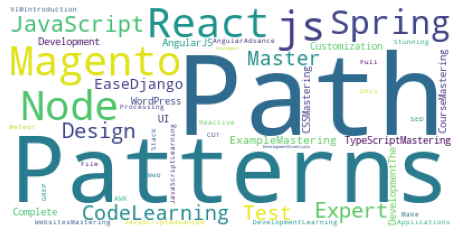

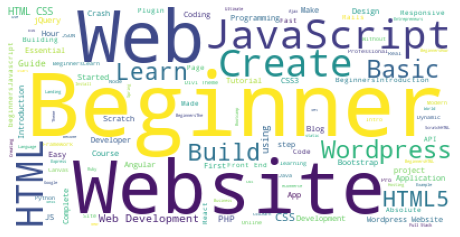

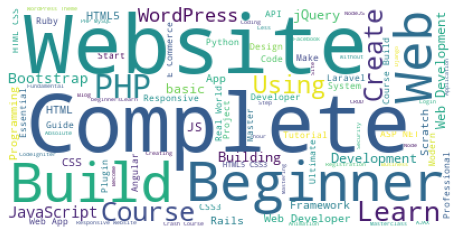

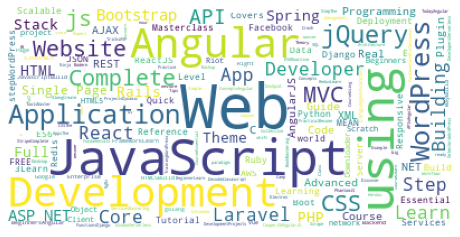

In [13]:
for i in level_cats:
    text = data[data['level'] == i]
    text =  ''.join(text[text['subject'] == 'Web Development']['course_title'])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=1000).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.show()

## Musical Instruments courses

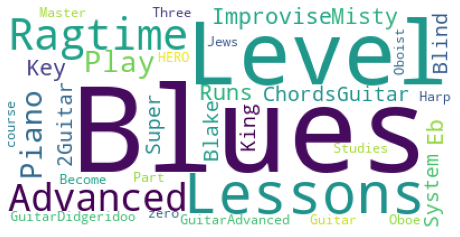

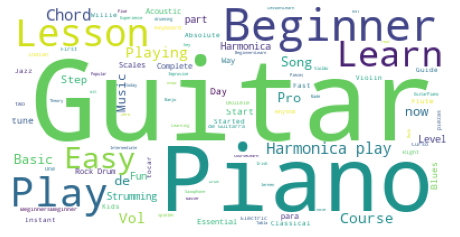

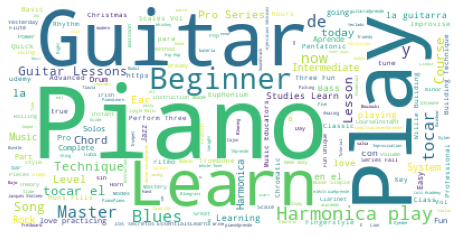

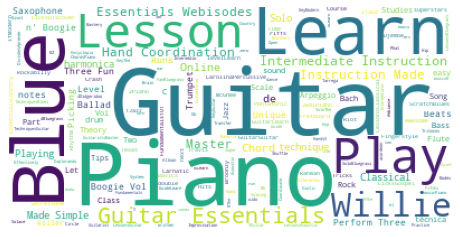

In [14]:
for i in level_cats:
    text = data[data['level'] == i]
    text =  ''.join(text[text['subject'] == 'Musical Instruments']['course_title'])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=1000).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.show()